# Psychometric Predictive Power and Sensitivity

In [186]:
### Import and utils
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from collections import defaultdict
from tqdm.notebook import tqdm
from typing import List

# For local imports
import sys
sys.path.append('../../')

In [187]:
def load_data(data_dir: str, columns: List[str]):
    """
    Load data from a directory of CSV files containing surprisal estimates.
    # Arguments:
        data_dir: Path to directory containing CSV files.
        columns: List of columns to load from CSV files. If None, all columns are loaded.
    """
    data = None
    for file in os.listdir(data_dir):
        if file.endswith(".csv"):
            fields_from_filename = parse_filename(file)
            df = pd.read_csv(os.path.join(data_dir, file), usecols=columns)
            for field in fields_from_filename:
                df[field] = fields_from_filename[field]

            if "data" in locals():
                data = pd.concat([data, df])
            else:
                data = df
    print(f"Size of dataset: {len(data)} rows")
    return data

def parse_filename(filename: str):
    """
    Parse a filename of the form into a dictionary of fields.
    # Arguments:
        filename: Filename to parse.
    """
    corpus, model, sampling_str, _, _, _ = filename.split("-")
    if len(sampling_str.split("_")) == 1:
        sampling = sampling_str
        sampling_param = "None"
    else:
        sampling, sampling_param = sampling_str.split("_")
    return {
        "corpus": corpus,
        "model": model,
        "sampling": sampling,
        "sampling_param": sampling_param
    }


In [188]:
# DATASETS = ['switchboard', 'dailydialog', 'provo'] #'brown', 'ns', 'provo', 'BLL2018',
DATASETS = ['switchboard', 'dailydialog', 'brown', 'ns', 'provo', 'BLL2018']

DATASET_CONTEXT_MAP = {
    'switchboard': 'switchboard/switchboard_results_is.jsonl', 
    'dailydialog': 'dailydialog/dailydialog_results_is.jsonl', 
    'BLL2018': 'BLL2018/processed_ratings.jsonl',
    'brown': 'RTs/brown_rt.jsonl', 
    'ns': 'RTs/ns_rt.jsonl', 
    'provo': 'RTs/provo_rt.jsonl',
                      }

CORPUS_NAMES = {
    'switchboard': 'Switchboard',             
    'dailydialog': 'Dailydialog',             
    'provo': 'Provo',             
    'brown': 'Brown',            
    'ns': 'Natural Stories', 
    'BLL2018': 'Clasp',
               }

SURPRISE_COLUMNS = [
    'surprise_mean_1gram', 'surprise_min_1gram', 'surprise_max_1gram',
    'surprise_mean_2gram_pos', 'surprise_min_2gram_pos', 'surprise_max_2gram_pos',
    'surprise_mean_cosine', 'surprise_min_cosine', 'surprise_max_cosine',
    'surprise_ooc_mean_1gram', 'surprise_ooc_min_1gram', 'surprise_ooc_max_1gram',
    'surprise_ooc_mean_2gram_pos', 'surprise_ooc_min_2gram_pos', 'surprise_ooc_max_2gram_pos',
    'surprise_ooc_mean_cosine', 'surprise_ooc_min_cosine', 'surprise_ooc_max_cosine',
    'surprise_rnd_mean_1gram', 'surprise_rnd_min_1gram', 'surprise_rnd_max_1gram',
    'surprise_rnd_mean_2gram_pos', 'surprise_rnd_min_2gram_pos', 'surprise_rnd_max_2gram_pos',
    'surprise_rnd_mean_cosine', 'surprise_rnd_min_cosine', 'surprise_rnd_max_cosine',
]

In [189]:
### Load data

dfs = []
for dataset in DATASETS:
    print(f"Loading data for {dataset}...")
    DATA_DIR = f"../../../data/surprise_tidy_2jun/{dataset}"

    if dataset in ['switchboard', 'dailydialog']:
        COLUMNS = [
            'context_id', 'target_id', 'real', 'mean_acceptability', 'n_samples',
        ]
    elif dataset == 'BLL2018':
        COLUMNS = [
            'context_id', 'target_id', 'real', 'mean_acceptability_in_context',
            'mean_acceptability_out_of_context', 'n_samples'
        ]
    elif dataset in ['brown', 'ns', 'provo']:
        COLUMNS = [
            'context_id', 'time_mean_NO', 'n_samples'
        ]
    else:
        raise ValueError(f"Unknown dataset: {dataset}")

    COLUMNS = COLUMNS + SURPRISE_COLUMNS
    df = load_data(DATA_DIR, COLUMNS)

    # Prettify column and value names
    df["corpus"] = df["corpus"].map(CORPUS_NAMES)
    df["sampling"] = df["sampling"].str.capitalize()
    df["sampling"] = df["sampling"].str.replace("Temp", "Temperature")
    
    model_name_map = {
        'gpt2': 'GPT-2 Small',
        'gpt2_medium': 'GPT-2 Medium',
        'gpt2_large': 'GPT-2 Large',
        'dialogpt_small': 'DialoGPT Small',
        'dialogpt_medium': 'DialoGPT Medium',
        'dialogpt_large': 'DialoGPT Large',
        'opt_125m': 'OPT 125M',
        'opt_350m': 'OPT 350M',
        'opt_1.3b': 'OPT 1.3B',
        'gpt_neo_125m': 'GPT-Neo 125M',
        'gpt_neo_1.3b': 'GPT-Neo 1.3B'
    }
    df["model"] = df["model"].map(model_name_map)

    metric_name_map = {
        'surprise_mean_1gram': 'Lexical information value (mean)',
        'surprise_min_1gram': 'Lexical information value (min)',
        'surprise_mean_2gram_pos': 'Syntactic information value (mean)',
        'surprise_min_2gram_pos': 'Syntactic information value (min)',
        'surprise_mean_cosine': 'Semantic information value (mean)',
        'surprise_min_cosine': 'Semantic information value (min)',
        'surprise_ooc_mean_1gram': 'Lexical information value OOC (mean)',
        'surprise_ooc_min_1gram': 'Lexical information value OOC (min)',
        'surprise_ooc_mean_2gram_pos': 'Syntactic information value OOC (mean)',
        'surprise_ooc_min_2gram_pos': 'Syntactic information value OOC (min)',
        'surprise_ooc_mean_cosine': 'Semantic information value OOC (mean)',
        'surprise_ooc_min_cosine': 'Semantic information value OOC (min)',
        'surprise_rnd_mean_1gram': 'Lexical information value RND (mean)',
        'surprise_rnd_min_1gram': 'Lexical information value RND (min)',
        'surprise_rnd_mean_2gram_pos': 'Syntactic information value RND (mean)',
        'surprise_rnd_min_2gram_pos': 'Syntactic information value RND (min)',
        'surprise_rnd_mean_cosine': 'Semantic information value RND (mean)',
        'surprise_rnd_min_cosine': 'Semantic information value RND (min)',
    }
    df = df.rename(columns=metric_name_map)

    sampling_param_map = {
        "None": "None", "02": "0.2", "03": "0.3", "075": "0.75", "08": "0.8",
        "085": "0.85", "09": "0.9", "095": "0.95", "125": "1.25"
    }
    df["sampling_param"] = df["sampling_param"].map(sampling_param_map)

    dfs.append(df)

data = pd.concat(dfs, axis=0, ignore_index=True)


Loading data for switchboard...
Size of dataset: 88000 rows
Loading data for dailydialog...
Size of dataset: 88000 rows
Loading data for brown...
Size of dataset: 396000 rows
Loading data for ns...
Size of dataset: 377720 rows
Loading data for provo...
Size of dataset: 119680 rows
Loading data for BLL2018...
Size of dataset: 440000 rows


In [190]:
data.head()

context_id target_id  mean_acceptability  real  n_samples   
0   sw2278_5  sw2278_6                 4.6  True         10  \
1   sw2278_5  sw2278_6                 4.6  True         20   
2   sw2278_5  sw2278_6                 4.6  True         30   
3   sw2278_5  sw2278_6                 4.6  True         40   
4   sw2278_5  sw2278_6                 4.6  True         50   

   Lexical information value (mean)  Lexical information value (min)   
0                          0.939365                         0.844444  \
1                          0.951938                         0.818182   
2                          0.938907                         0.625000   
3                          0.952665                         0.625000   
4                          0.942222                         0.555556   

   surprise_max_1gram  Syntactic information value (mean)   
0                 1.0                            0.858733  \
1                 1.0                            0.864568   
2                 1.0                            0.847137   
3                 1.0                            0.874708   
4                 1.0                            0.876927   

   Syntactic information value (min)  ...   
0                           0.384615  ...  \
1                           0.384615  ...   
2                           0.384615  ...   
3                           0.384615  ...   
4                           0.384615  ...   

   Semantic information value RND (mean)   
0                               0.848682  \
1                               0.815512   
2                               0.818431   
3                               0.825032   
4                               0.831642   

   Semantic information value RND (min)  surprise_rnd_max_cosine       corpus   
0                              0.777190                 0.973214  Switchboard  \
1                              0.445545                 0.973214  Switchboard   
2                              0.445545                 0.973214  Switchboard   
3                              0.445545                 0.973214  Switchboard   
4                              0.445545                 0.973214  Switchboard   

          model  sampling  sampling_param  time_mean_NO   
0  GPT-Neo 125M   Nucleus             0.9           NaN  \
1  GPT-Neo 125M   Nucleus             0.9           NaN   
2  GPT-Neo 125M   Nucleus             0.9           NaN   
3  GPT-Neo 125M   Nucleus             0.9           NaN   
4  GPT-Neo 125M   Nucleus             0.9           NaN   

   mean_acceptability_in_context  mean_acceptability_out_of_context  
0                            NaN                                NaN  
1                            NaN                                NaN  
2                            NaN                                NaN  
3                            NaN                                NaN  
4                            NaN                                NaN  

[5 rows x 39 columns]

In [191]:
for corpus in data["corpus"].unique():
    print(corpus)
    print(data[data["corpus"] == corpus]["model"].unique())
    print(data[data["corpus"] == corpus]["sampling"].unique())
    print()


Switchboard
['GPT-Neo 125M' 'DialoGPT Medium' 'GPT-Neo 1.3B' 'GPT-2 Small'
 'DialoGPT Small' 'DialoGPT Large' 'GPT-2 Medium' 'GPT-2 Large']
['Nucleus' 'Temperature' 'Ancestral' 'Typical']

Dailydialog
['GPT-2 Medium' 'DialoGPT Large' 'GPT-2 Large' 'DialoGPT Medium'
 'GPT-Neo 125M' 'GPT-2 Small' 'GPT-Neo 1.3B' 'DialoGPT Small']
['Temperature' 'Typical' 'Nucleus' 'Ancestral']

Brown
['GPT-2 Large' 'GPT-Neo 125M' 'GPT-Neo 1.3B' 'GPT-2 Small' 'OPT 350M'
 'GPT-2 Medium' 'OPT 125M' 'OPT 1.3B']
['Typical' 'Temperature' 'Nucleus' 'Ancestral']

Natural Stories
['OPT 350M' 'GPT-Neo 125M' 'GPT-2 Large' 'GPT-2 Medium' 'OPT 125M'
 'GPT-Neo 1.3B' 'OPT 1.3B' 'GPT-2 Small']
['Typical' 'Temperature' 'Nucleus' 'Ancestral']

Provo
['OPT 350M' 'GPT-2 Small' 'GPT-2 Large' 'GPT-2 Medium' 'GPT-Neo 1.3B'
 'OPT 1.3B' 'OPT 125M' 'GPT-Neo 125M']
['Nucleus' 'Typical' 'Temperature' 'Ancestral']

Clasp
['GPT-Neo 1.3B' 'GPT-2 Medium' 'GPT-Neo 125M' 'GPT-2 Large' 'OPT 350M'
 'GPT-2 Small' 'OPT 125M' 'OPT 1.3B']
['Tem

In [192]:
# This function measures correlation:
# (1) between surprise metrics and psychometric data (quality)
# (2) between surprise metrics and each other (robustness)

def get_correlation_dfs(data, grouping_level1, grouping_level2):
    """
    :param data: dataframe with all corpora and measures
    :param grouping_level1: determines lines in correlation plots (e.g. 'model')
    :param grouping_level2: determines error bars in correlation plots (e.g. ['sampling', 'sampling_param',])
    :return: quality_correlations_dfs, robustness_correlations_dfs (dict of dicts of dataframes)
            (corpus -> measure -> dataframe with correlations)
    """

    MEASURES_OF_INTEREST = [
        "Lexical information value (mean)", "Syntactic information value (mean)", "Semantic information value (mean)",
        "Lexical information value (min)", "Syntactic information value (min)", "Semantic information value (min)",
        "Lexical information value OOC (mean)", "Syntactic information value OOC (mean)", "Semantic information value OOC (mean)",
        "Lexical information value OOC (min)", "Syntactic information value OOC (min)", "Semantic information value OOC (min)",
        "Lexical information value RND (mean)", "Syntactic information value RND (mean)", "Semantic information value RND (mean)",
        "Lexical information value RND (min)", "Syntactic information value RND (min)", "Semantic information value RND (min)",
    ]

    quality_correlations = {corpus: defaultdict(list) for corpus in data["corpus"].unique()}
    robustness_correlations = {corpus: defaultdict(list) for corpus in data["corpus"].unique()}

    for corpus in data["corpus"].unique():
        df_corpus = data[data["corpus"] == corpus]
        print(corpus, df_corpus.shape)

        print(f'Progressing {corpus}')
        for measure in tqdm(MEASURES_OF_INTEREST, desc='Measures of interest'):

            for n_samples in range(10, 101, 10):
                # Fix n_samples to n
                df_Nsamples = df_corpus[df_corpus["n_samples"] == n_samples]

                grouped_level1 = df_Nsamples.groupby(grouping_level1)
                for level1, group_level1 in grouped_level1:

                    grouped_level2 = group_level1.groupby(grouping_level2)

                    # QUALITY CORRELATIONS
                    # --------------------
                    if corpus in ["Switchboard", "Dailydialog"]:
                        psychometric_data_name = 'mean_acceptability'
                    elif corpus == "Clasp":
                        psychometric_data_name = 'mean_acceptability_in_context'
                    elif corpus in ['Brown', 'Natural Stories', 'Provo']:
                        psychometric_data_name = 'time_mean_NO'
                    else:
                        raise ValueError("Unknown corpus")

                    # Calculate the rank-correlation between surprisal and psychometric data
                    for i, (group_name, group) in enumerate(grouped_level2):
                        surprisal_vals = group[measure].tolist()
                        psychometric_vals = group[psychometric_data_name].tolist()
                        corr_stat, corr_pval = spearmanr(surprisal_vals, psychometric_vals, nan_policy="omit")
                        quality_correlations[corpus][measure].append((level1, n_samples, group_name, corr_stat, corr_pval))
                        # Note:
                        # nan_policy="omit": bigrams are not defined for one-word productions
                        # ConstantInputWarning due to lexical surprisal being always 1
                    # --------------------

                    # ROBUSTNESS CORRELATIONS
                    # --------------------
                    # Calculate the rank-correlation between all pairs of surprisal lists
                    for i, (group_i_name, group_i) in enumerate(grouped_level2):
                        for j, (group_j_name, group_j) in enumerate(grouped_level2):
                            if i == j:
                                continue  # Skip diagonal
                            values_i = group_i[measure].tolist()
                            values_j = group_j[measure].tolist()
#                             print(group_i_name, len(values_i), group_j_name, len(values_j))
                            corr_stat, corr_pval = spearmanr(values_i, values_j, nan_policy="omit")
                            robustness_correlations[corpus][measure].append(
                                (level1, n_samples, group_i_name, group_j_name, corr_stat, corr_pval)
                            )

    # Create a dataframe for each corpus and measure
    quality_correlations_dfs = {}
    robustness_correlations_dfs = {}

    for corpus in quality_correlations:

        quality_correlations_dfs[corpus] = {}
        robustness_correlations_dfs[corpus] = {}

        for measure in quality_correlations[corpus]:

            grouping_level1_name = '_'.join(grouping_level1) if type(grouping_level1) == list else grouping_level1
            grouping_level2_name = '_'.join(grouping_level2) if type(grouping_level2) == list else grouping_level2

            # Quality correlations
            df_tmp = pd.DataFrame(quality_correlations[corpus][measure], columns=[
                grouping_level1_name, "n_samples", grouping_level2_name, "corr", "pval"
            ])
            quality_correlations_dfs[corpus][measure] = df_tmp

            # Robustness correlations
            df_tmp = pd.DataFrame(robustness_correlations[corpus][measure], columns=[
                grouping_level1_name, "n_samples", f"{grouping_level2_name}_i", f"{grouping_level2_name}_j", "corr", "pval"
            ])
            robustness_correlations_dfs[corpus][measure] = df_tmp

    return quality_correlations_dfs, robustness_correlations_dfs


In [237]:
# Convenience function for plotting correlations

def plot_correlations_over_nsamples(correlations_dfs, hue, baseline=None, corpora=None, save=None):
    """
    :param correlations_dfs: dict of dict of dataframes (corpus -> measure -> dataframe of correlations)
    :param hue: str, column name to use for hue
    :param save: str, path to save the figure
    """

    MEASURES_OF_INTEREST_IC_OOC_IRC = [
        ("Lexical information value (mean)", "Lexical information value OOC (mean)", "Lexical information value RND (mean)"),
        ("Syntactic information value (mean)", "Syntactic information value OOC (mean)", "Syntactic information value RND (mean)"),
        ("Semantic information value (mean)", "Semantic information value OOC (mean)", "Semantic information value RND (mean)"),
        ("Lexical information value (min)", "Lexical information value OOC (min)", "Lexical information value RND (min)"),
        ("Syntactic information value (min)", "Syntactic information value OOC (min)", "Syntactic information value RND (min)"),
        ("Semantic information value (min)", "Semantic information value OOC (min)", "Semantic information value RND (min)"),
    ]

    if corpora is None:
        corpora = correlations_dfs.keys()
    for corpus in corpora:
        fig, axes = plt.subplots(2, 3, figsize=(24, 10))
        fig.suptitle(f'{corpus}', fontsize=30)

        for i, (measure_ic, measure_ooc, measure_rnd) in enumerate(MEASURES_OF_INTEREST_IC_OOC_IRC):
            # Get the correct subplot
            ax = axes[i // 3, i % 3]
            sns.lineplot(
                data=correlations_dfs[corpus][measure_ic],
                x='n_samples', y='corr', hue=hue,
                ax=ax, linewidth=3, style="model", markers=True, markersize=14, dashes=False, palette='colorblind', errorbar=('ci', 90)
            )

            if baseline == 'out-of-context':
                sns.lineplot(
                    data=correlations_dfs[corpus][measure_ooc],
                    x='n_samples', y='corr', hue=hue, # errorbar=None,
                    ax=ax,  linewidth=3, style="model", markers=True, markersize=14, dashes=False, palette='colorblind', errorbar=('ci', 90), legend=0
                )

            elif baseline == 'random-context':
                sns.lineplot(
                    data=correlations_dfs[corpus][measure_rnd],
                    x='n_samples', y='corr', hue=hue, # errorbar=None,
                    ax=ax,  linewidth=3, style="model", markers=True, markersize=14, dashes=False, palette='colorblind', errorbar=('ci', 90), legend=0
                )

            ax.set_title(measure_ic, fontsize=28)
            ax.set_xticks(np.arange(10, 110, 10))
            ax.get_legend().remove()

            # Set x and y labels only if it's the first subfigure in the row or the last in the column
            ax.set_xlabel('Alternative Set Size' if i // 3 == 1 else '')
            ax.set_ylabel('Rank-Correlation' if i % 3 == 0 else '')

        # Place legend outside of the subplots
        handles, labels = ax.get_legend_handles_labels()
        fig.legend(handles, labels, bbox_to_anchor=(0.73, 0.0), framealpha=0.1, ncols=3)

        plt.tight_layout()
        if save:
            plt.savefig(f"{os.path.join(save, corpus)}_ppo", dpi=100)
            plt.figure()
        else:
            plt.figure()
            plt.show()



In [194]:
quality_correlation_dfs, robustness_correlation_dfs = get_correlation_dfs(
    data,
    grouping_level1='model',
    grouping_level2=['sampling', 'sampling_param']
)

Switchboard (88000, 39)
Progressing Switchboard


Measures of interest:   0%|          | 0/18 [00:00<?, ?it/s]

Dailydialog (88000, 39)
Progressing Dailydialog


Measures of interest:   0%|          | 0/18 [00:00<?, ?it/s]

Brown (396000, 39)
Progressing Brown


Measures of interest:   0%|          | 0/18 [00:00<?, ?it/s]

/Users/mario/code/surprise/venv/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/mario/code/surprise/venv/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/mario/code/surprise/venv/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/mario/code/surprise/venv/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/mario/code/surprise/venv/lib/python3.

Natural Stories (377720, 39)
Progressing Natural Stories


Measures of interest:   0%|          | 0/18 [00:00<?, ?it/s]

/Users/mario/code/surprise/venv/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/mario/code/surprise/venv/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/mario/code/surprise/venv/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/mario/code/surprise/venv/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/mario/code/surprise/venv/lib/python3.

Provo (119680, 39)
Progressing Provo


Measures of interest:   0%|          | 0/18 [00:00<?, ?it/s]

/Users/mario/code/surprise/venv/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/mario/code/surprise/venv/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/mario/code/surprise/venv/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/mario/code/surprise/venv/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/mario/code/surprise/venv/lib/python3.

Clasp (440000, 39)
Progressing Clasp


Measures of interest:   0%|          | 0/18 [00:00<?, ?it/s]

/Users/mario/code/surprise/venv/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/mario/code/surprise/venv/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/mario/code/surprise/venv/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/mario/code/surprise/venv/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/mario/code/surprise/venv/lib/python3.

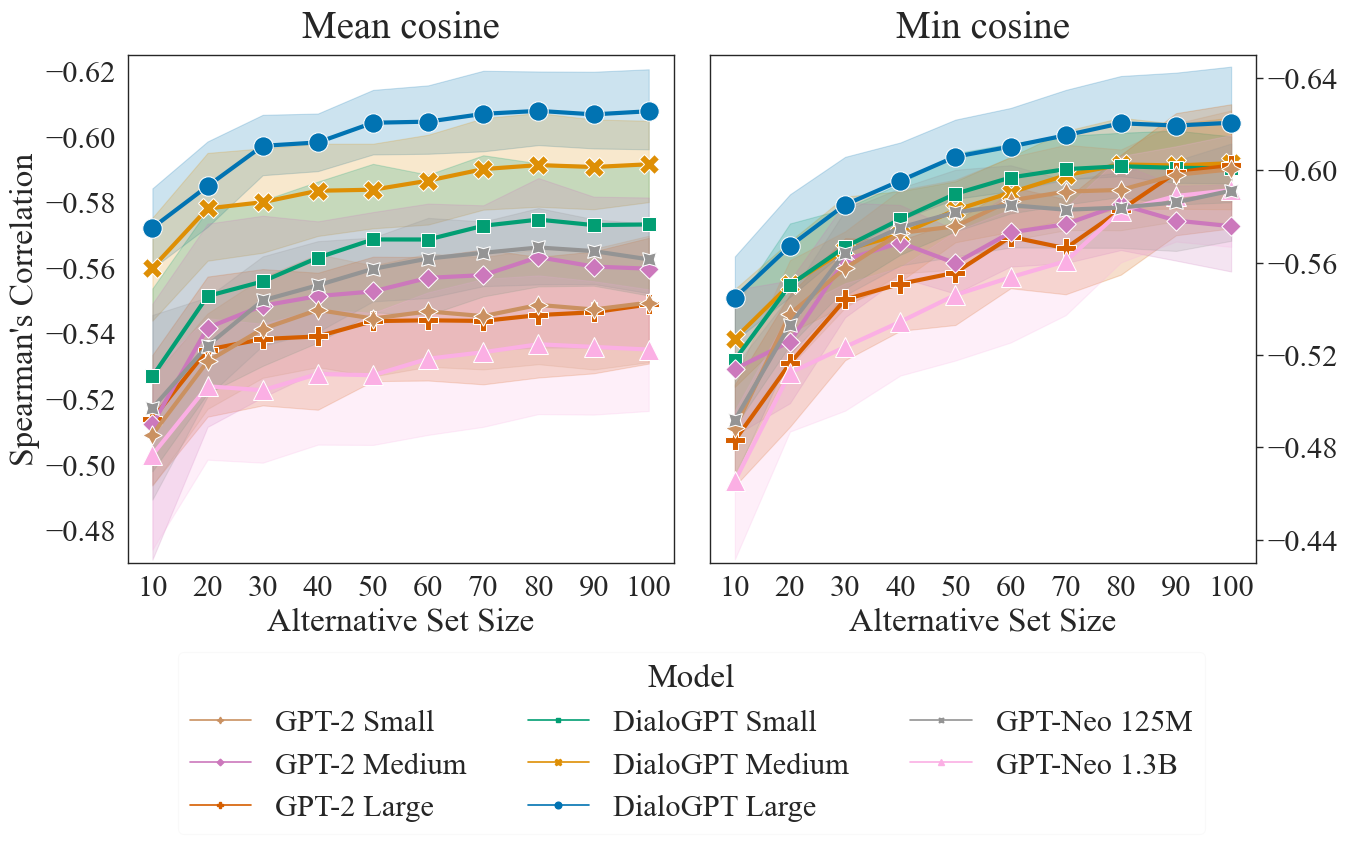

In [228]:
# Plots
sns.set_palette('colorblind')
sns.set_style('white', {'font.family': 'Times New Roman'})
sns.set_context("paper", font_scale=2.5)

fig, axes = plt.subplots(1, 2, figsize=(14, 7))

sns.lineplot(
    data=quality_correlation_dfs['Switchboard']['Semantic information value (mean)'],
    x='n_samples', y='corr', hue="model",
    ax=axes[0], linewidth=3, style="model", markers=True, markersize=14, dashes=False, palette='colorblind',
    errorbar=('ci', 90)
)

sns.lineplot(
    data=quality_correlation_dfs['Switchboard']['Semantic information value (min)'],
    x='n_samples', y='corr', hue="model",
    ax=axes[1], linewidth=3, style="model", markers=True, markersize=14, dashes=False, palette='colorblind',
    errorbar=('ci', 90)
)

axes[0].set_title("Mean cosine", fontsize=28, y=1.02)
axes[1].set_title("Min cosine", fontsize=28, y=1.02)
axes[0].set_xticks(np.arange(10, 110, 10))
axes[1].set_xticks(np.arange(10, 110, 10))
axes[1].yaxis.tick_right()
# axes[1]..tick_params(bottom=False)
# axes[1].xaxis.set_ticks_position('none')
axes[0].set_yticks(np.arange(-0.64, -0.39, 0.02))
axes[1].set_yticks(np.arange(-0.64, -0.39, 0.04))
# axes[1].tick_params(axis='y', colors='white')
axes[0].set_ylim(-0.47, -0.625)
axes[1].set_ylim(-0.43, -0.65)
axes[0].set_xlabel('Alternative Set Size')
axes[1].set_xlabel('Alternative Set Size')
axes[0].set_ylabel("Spearman's Correlation")
axes[1].set_ylabel('')
axes[0].get_legend().remove()
axes[1].get_legend().remove()
# axes[1].xaxis.grid(True)
# axes[1].yaxis.grid(True)
#
# # reordering the labels
# handles, labels = axes[1].get_legend_handles_labels()
# order = [5, 4, 3, 2, 1, 0, 7, 6]
# axes[0].legend(title='Model', handles=[handles[i] for i in order], labels=[labels[i] for i in order])
# axes[1].legend(title='Model', loc='best', handles=[handles[i] for i in order], labels=[labels[i] for i in order])
#
handles, labels = axes[0].get_legend_handles_labels()
order = [5, 4, 3, 2, 1, 0, 7, 6]
lgd = fig.legend(
    title='Model',
    handles=[handles[i] for i in order],
    labels=[labels[i] for i in order],
    loc='center right',
    # fontsize=14,
    bbox_to_anchor=(0.89, -0.1),
    ncol=3,
    framealpha=0.1
)
# sns.despine()
plt.tight_layout()
plt.savefig("../../../figures/switchboard_ppo_cosine", dpi=100, bbox_extra_artists=(lgd,), bbox_inches='tight')

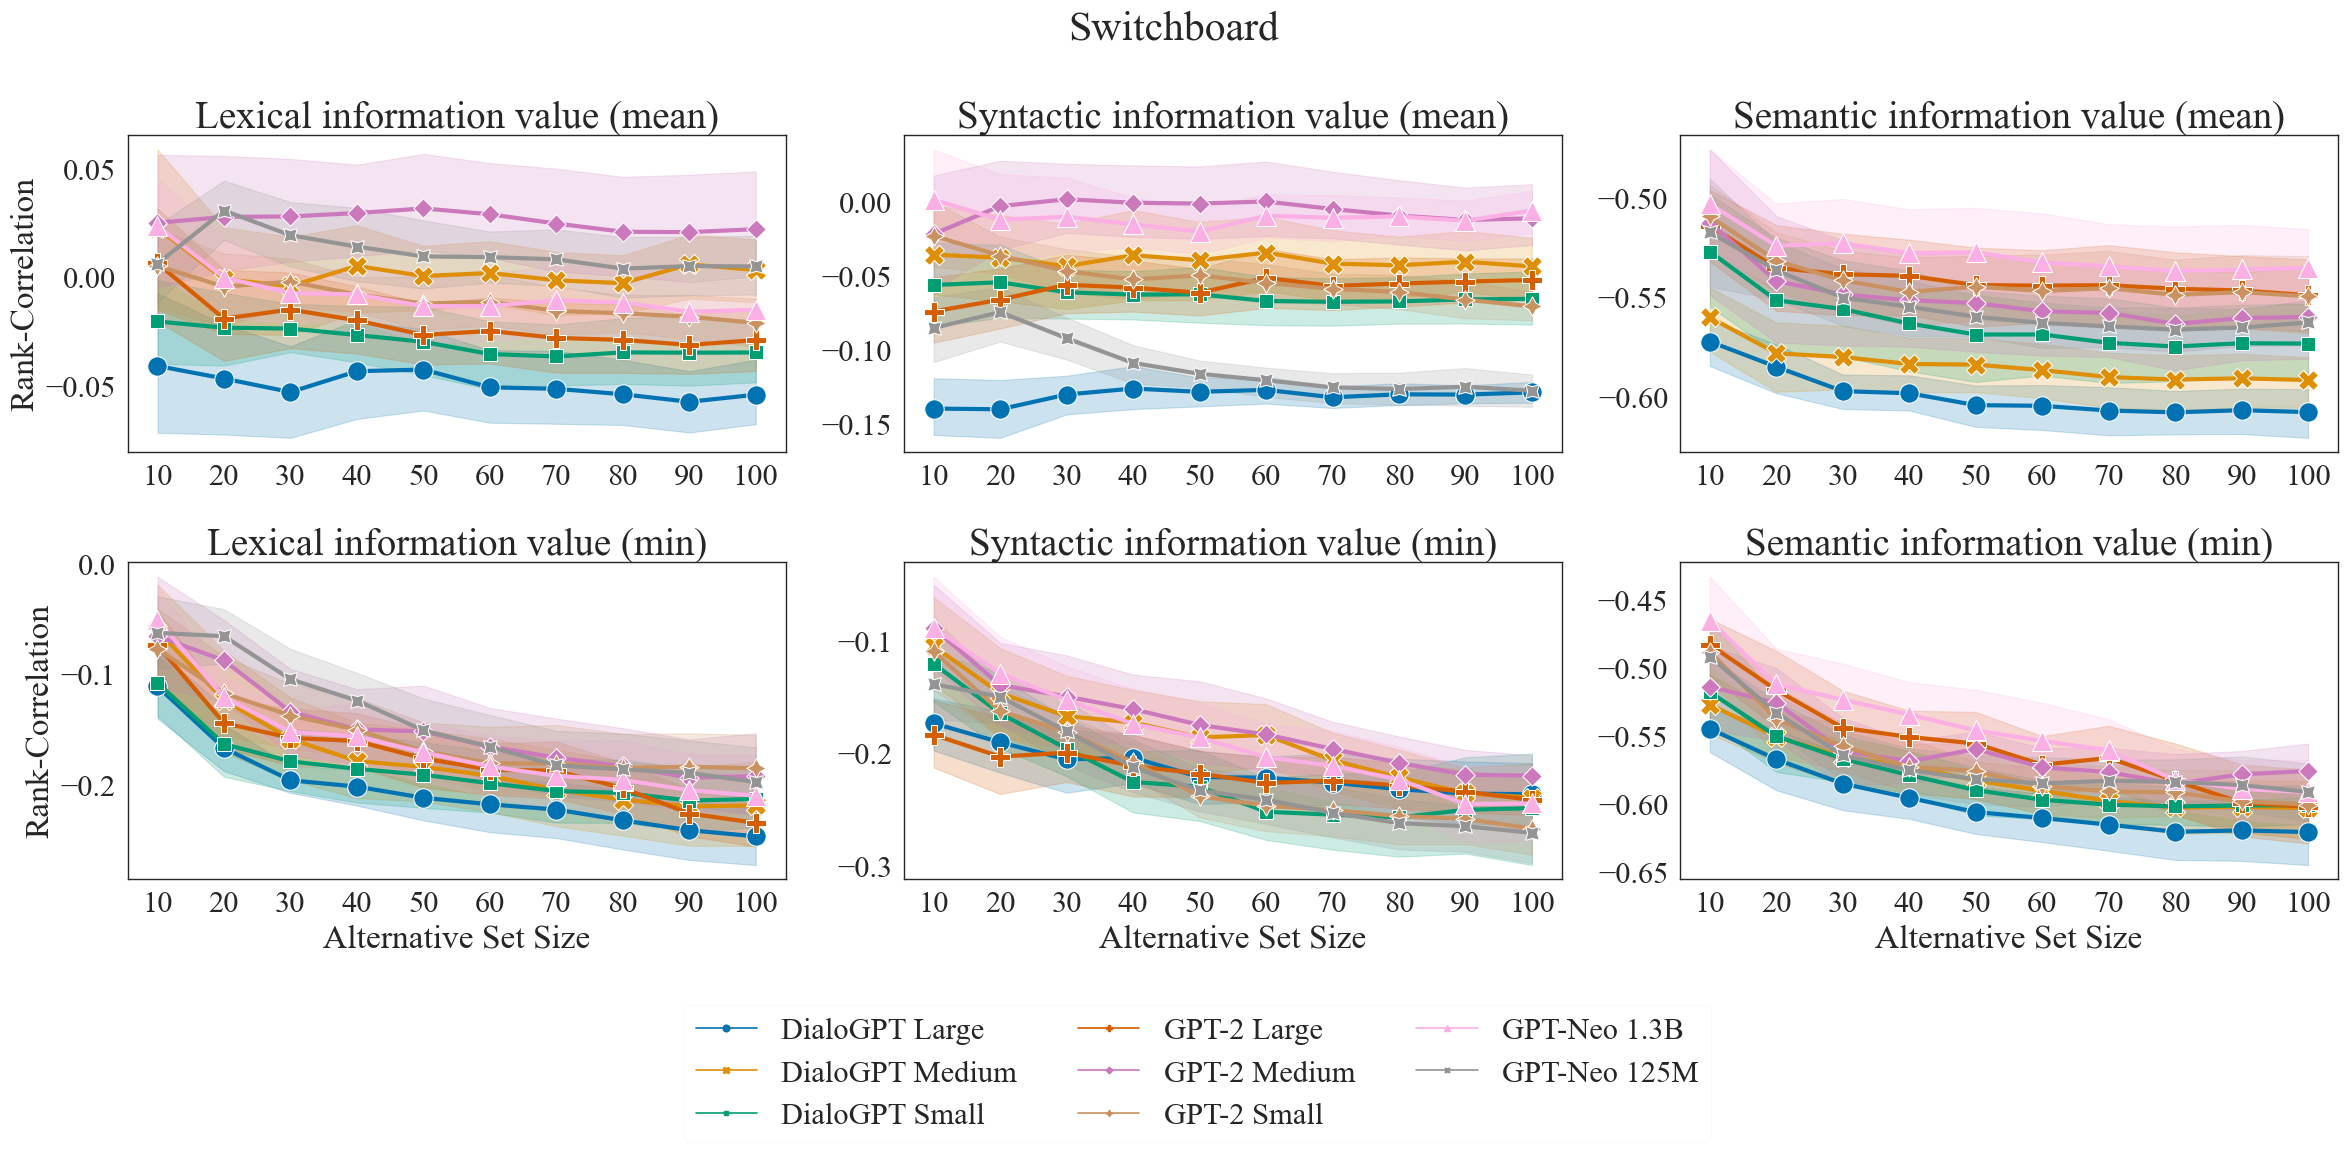

<Figure size 640x480 with 0 Axes>

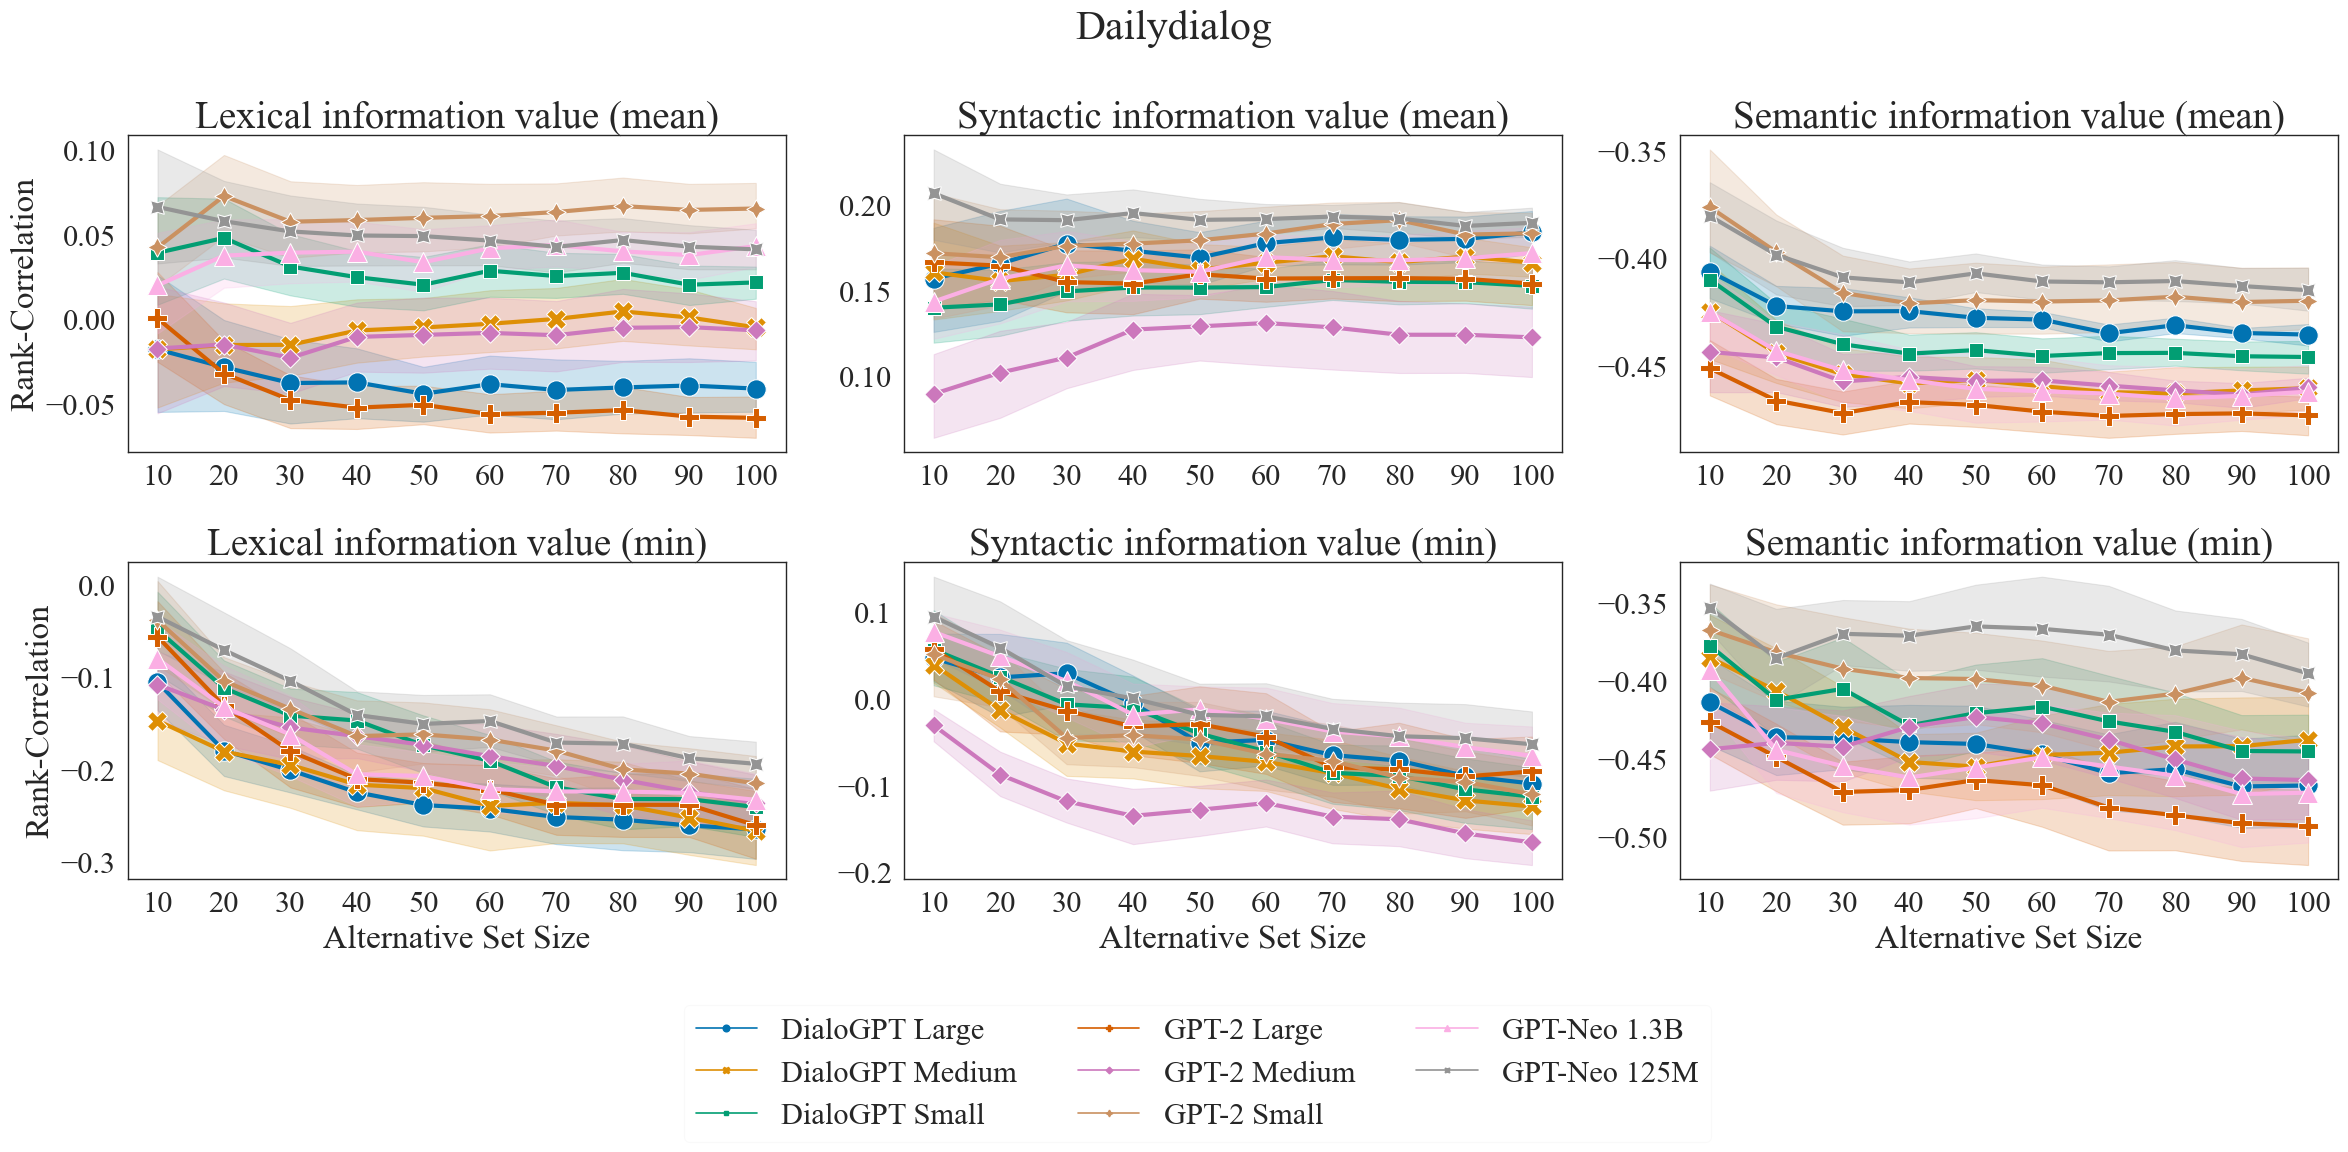

<Figure size 640x480 with 0 Axes>

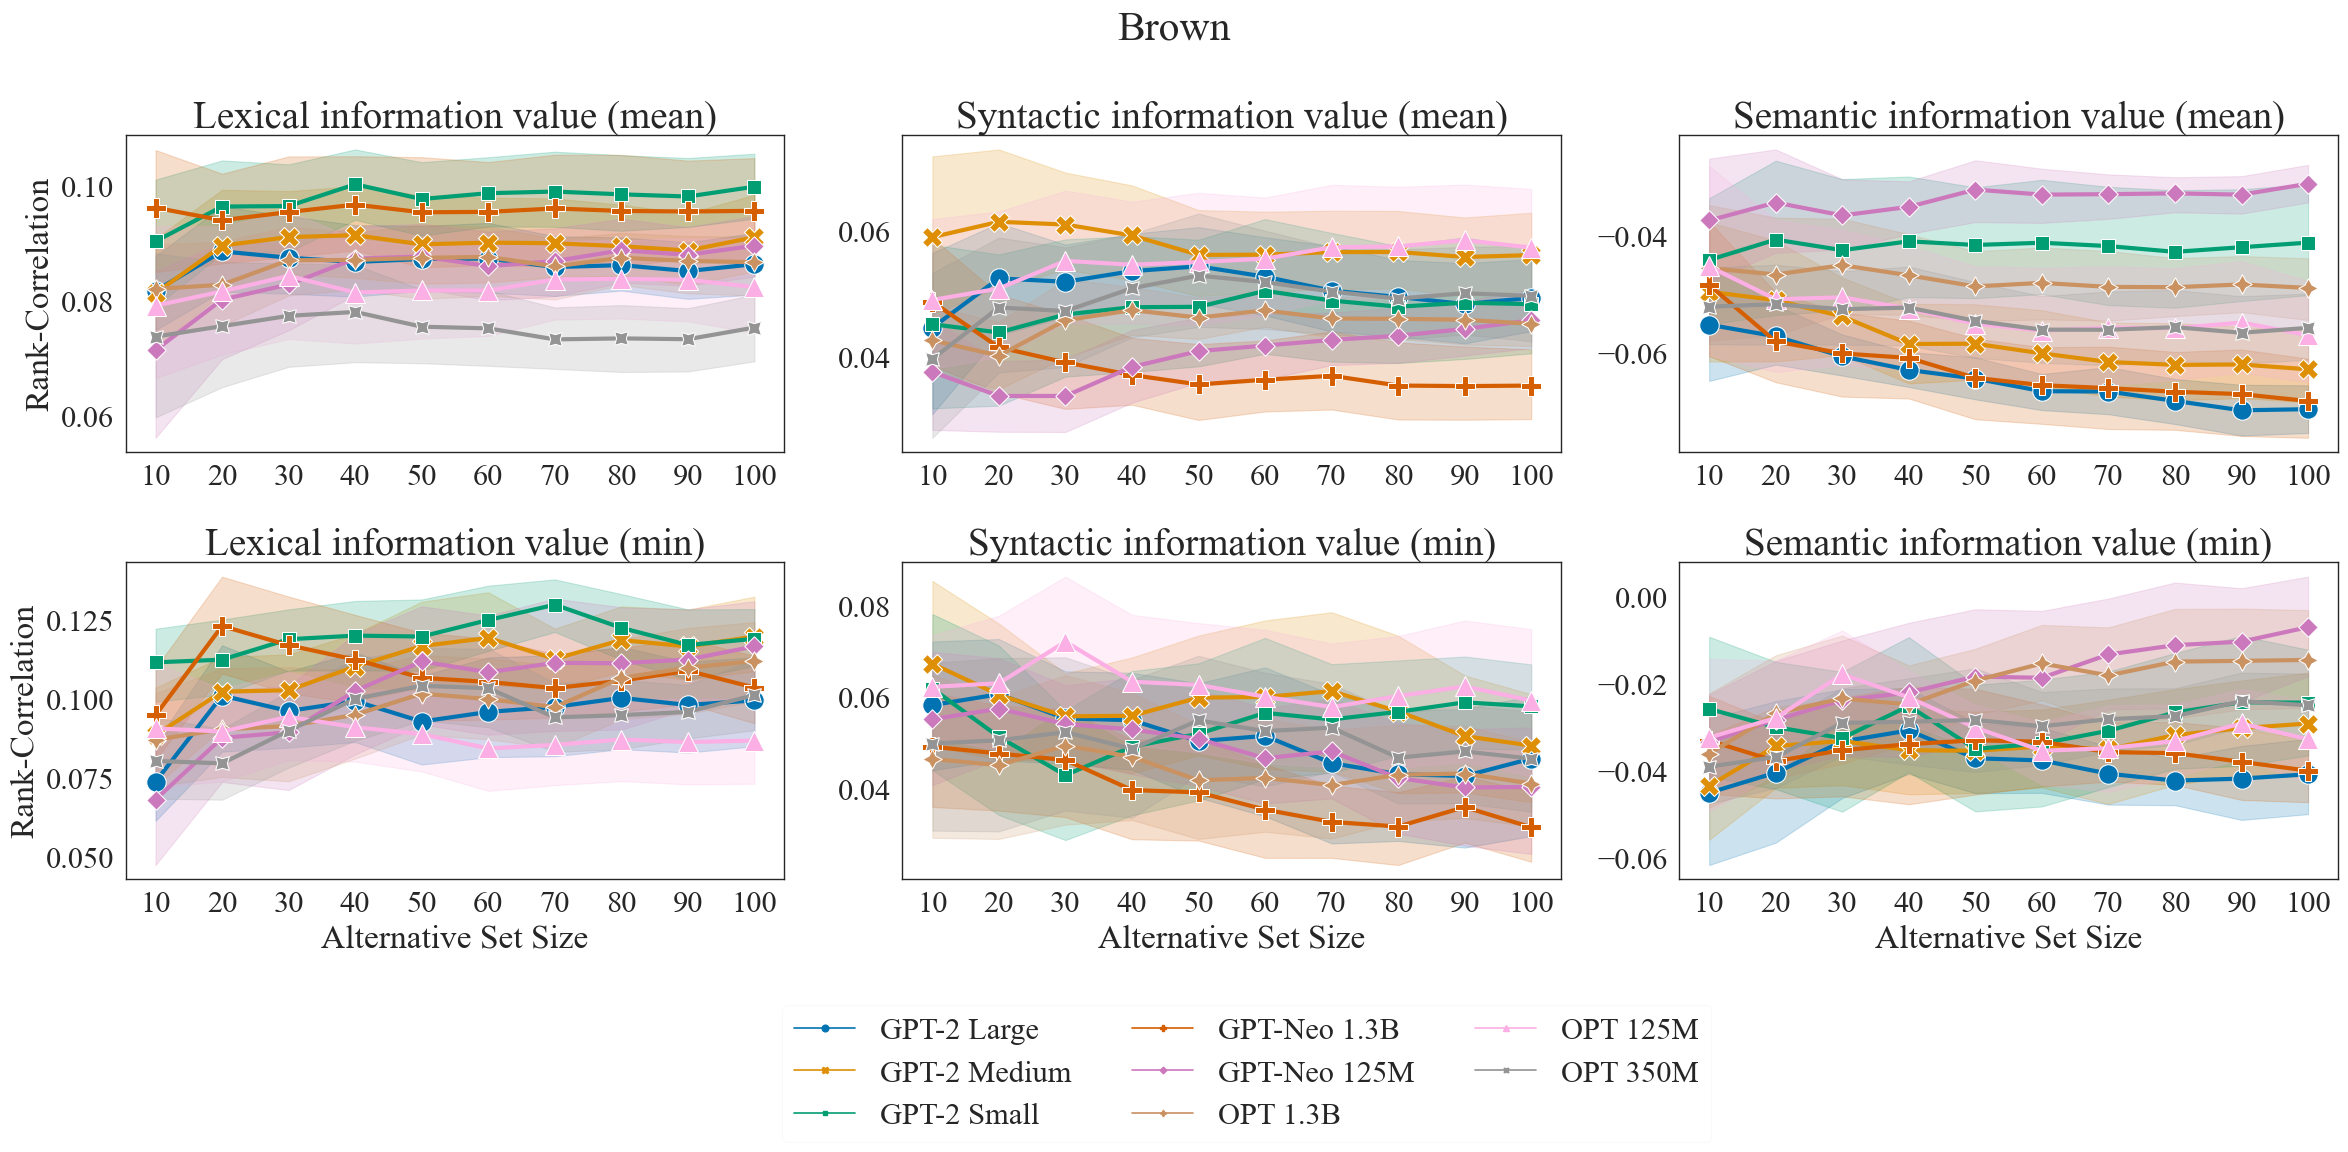

<Figure size 640x480 with 0 Axes>

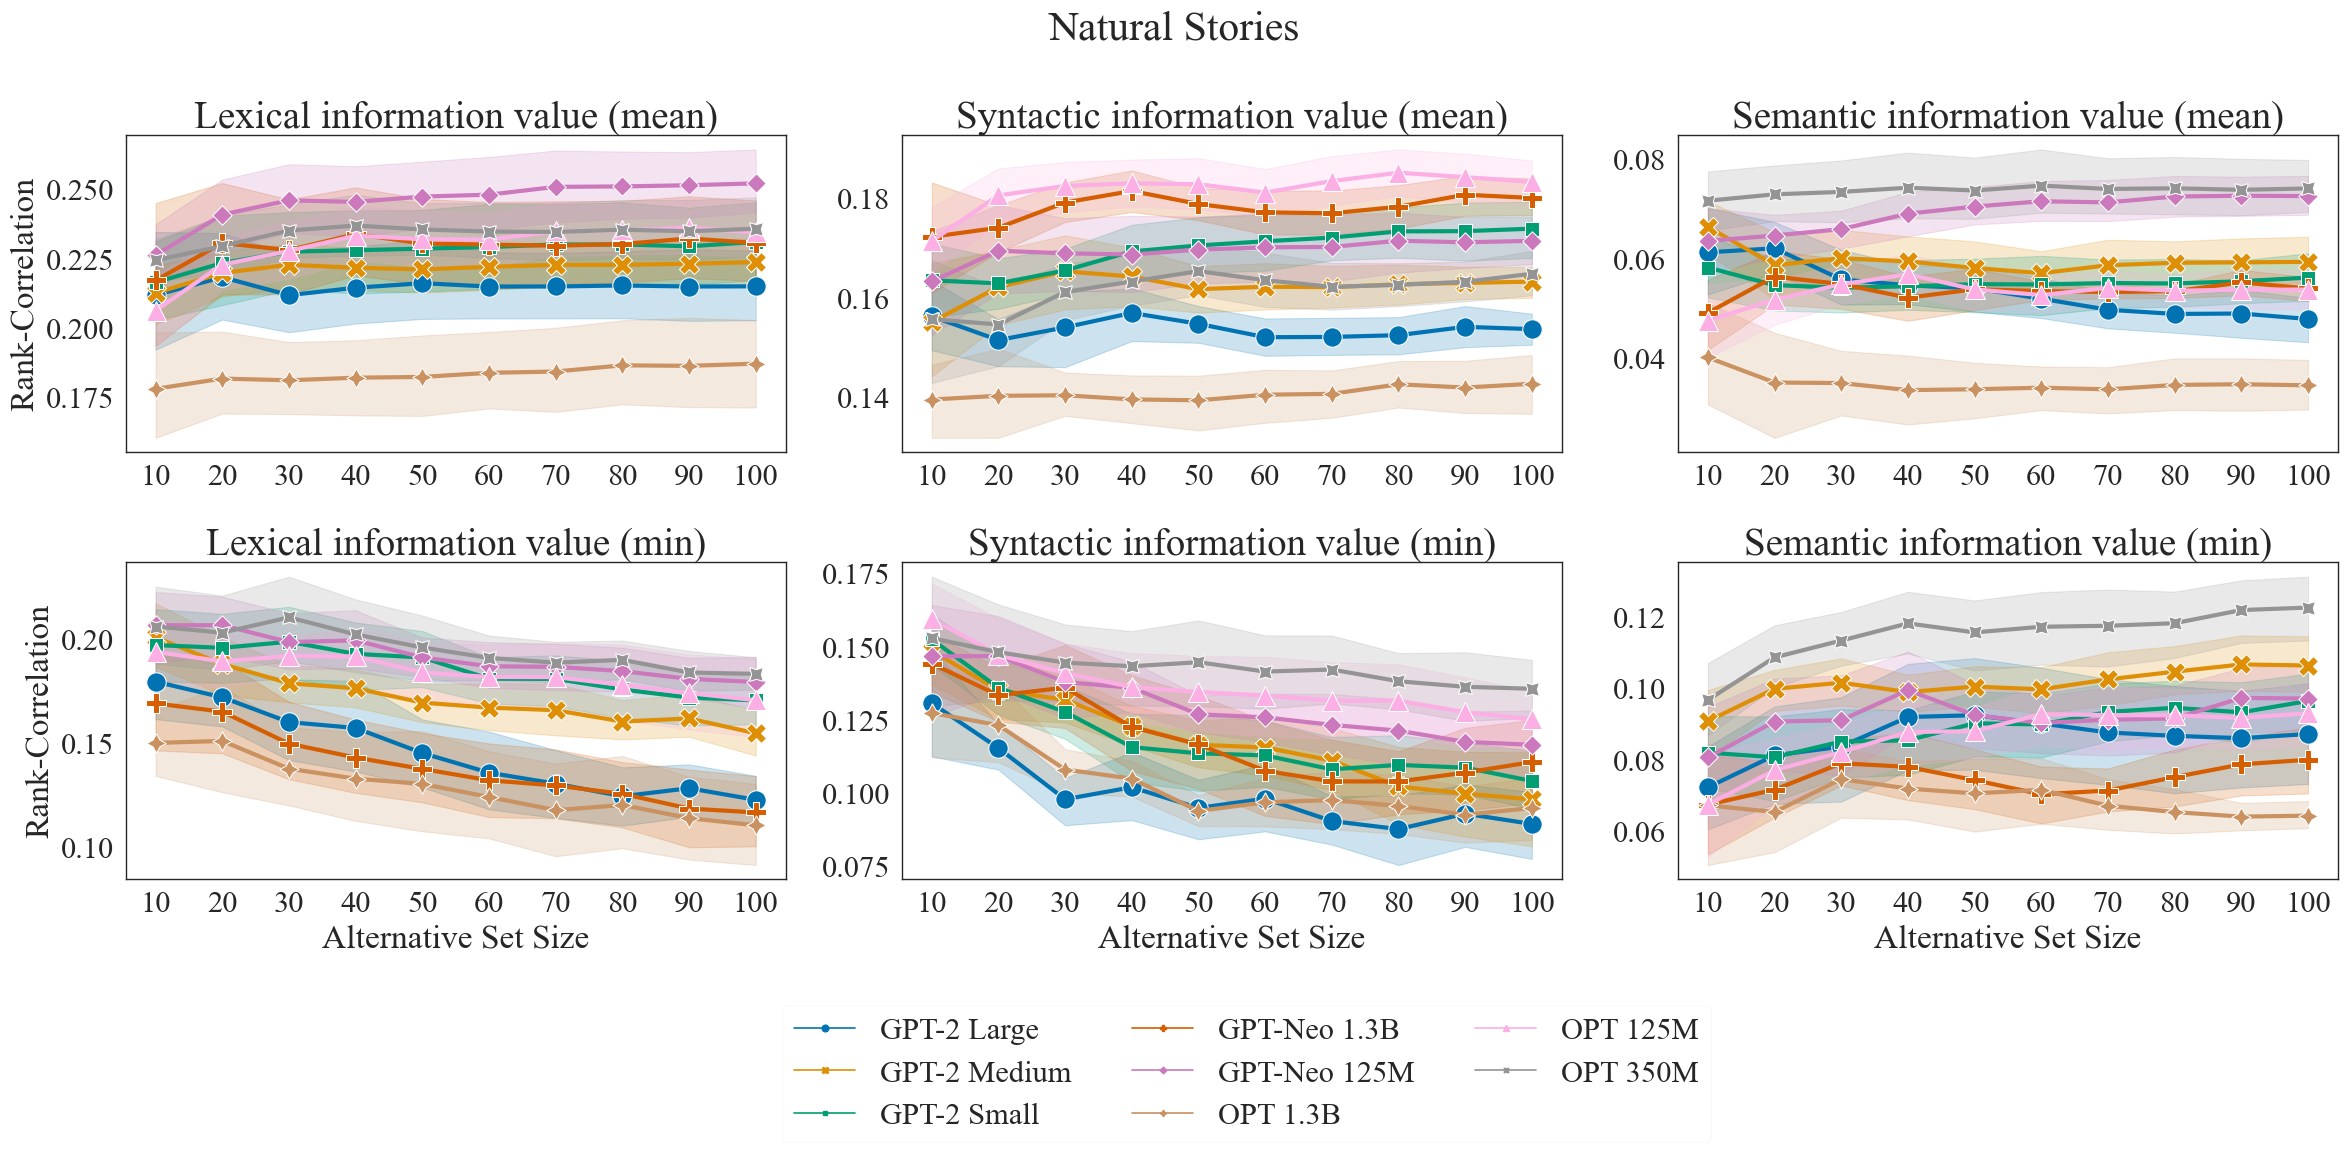

<Figure size 640x480 with 0 Axes>

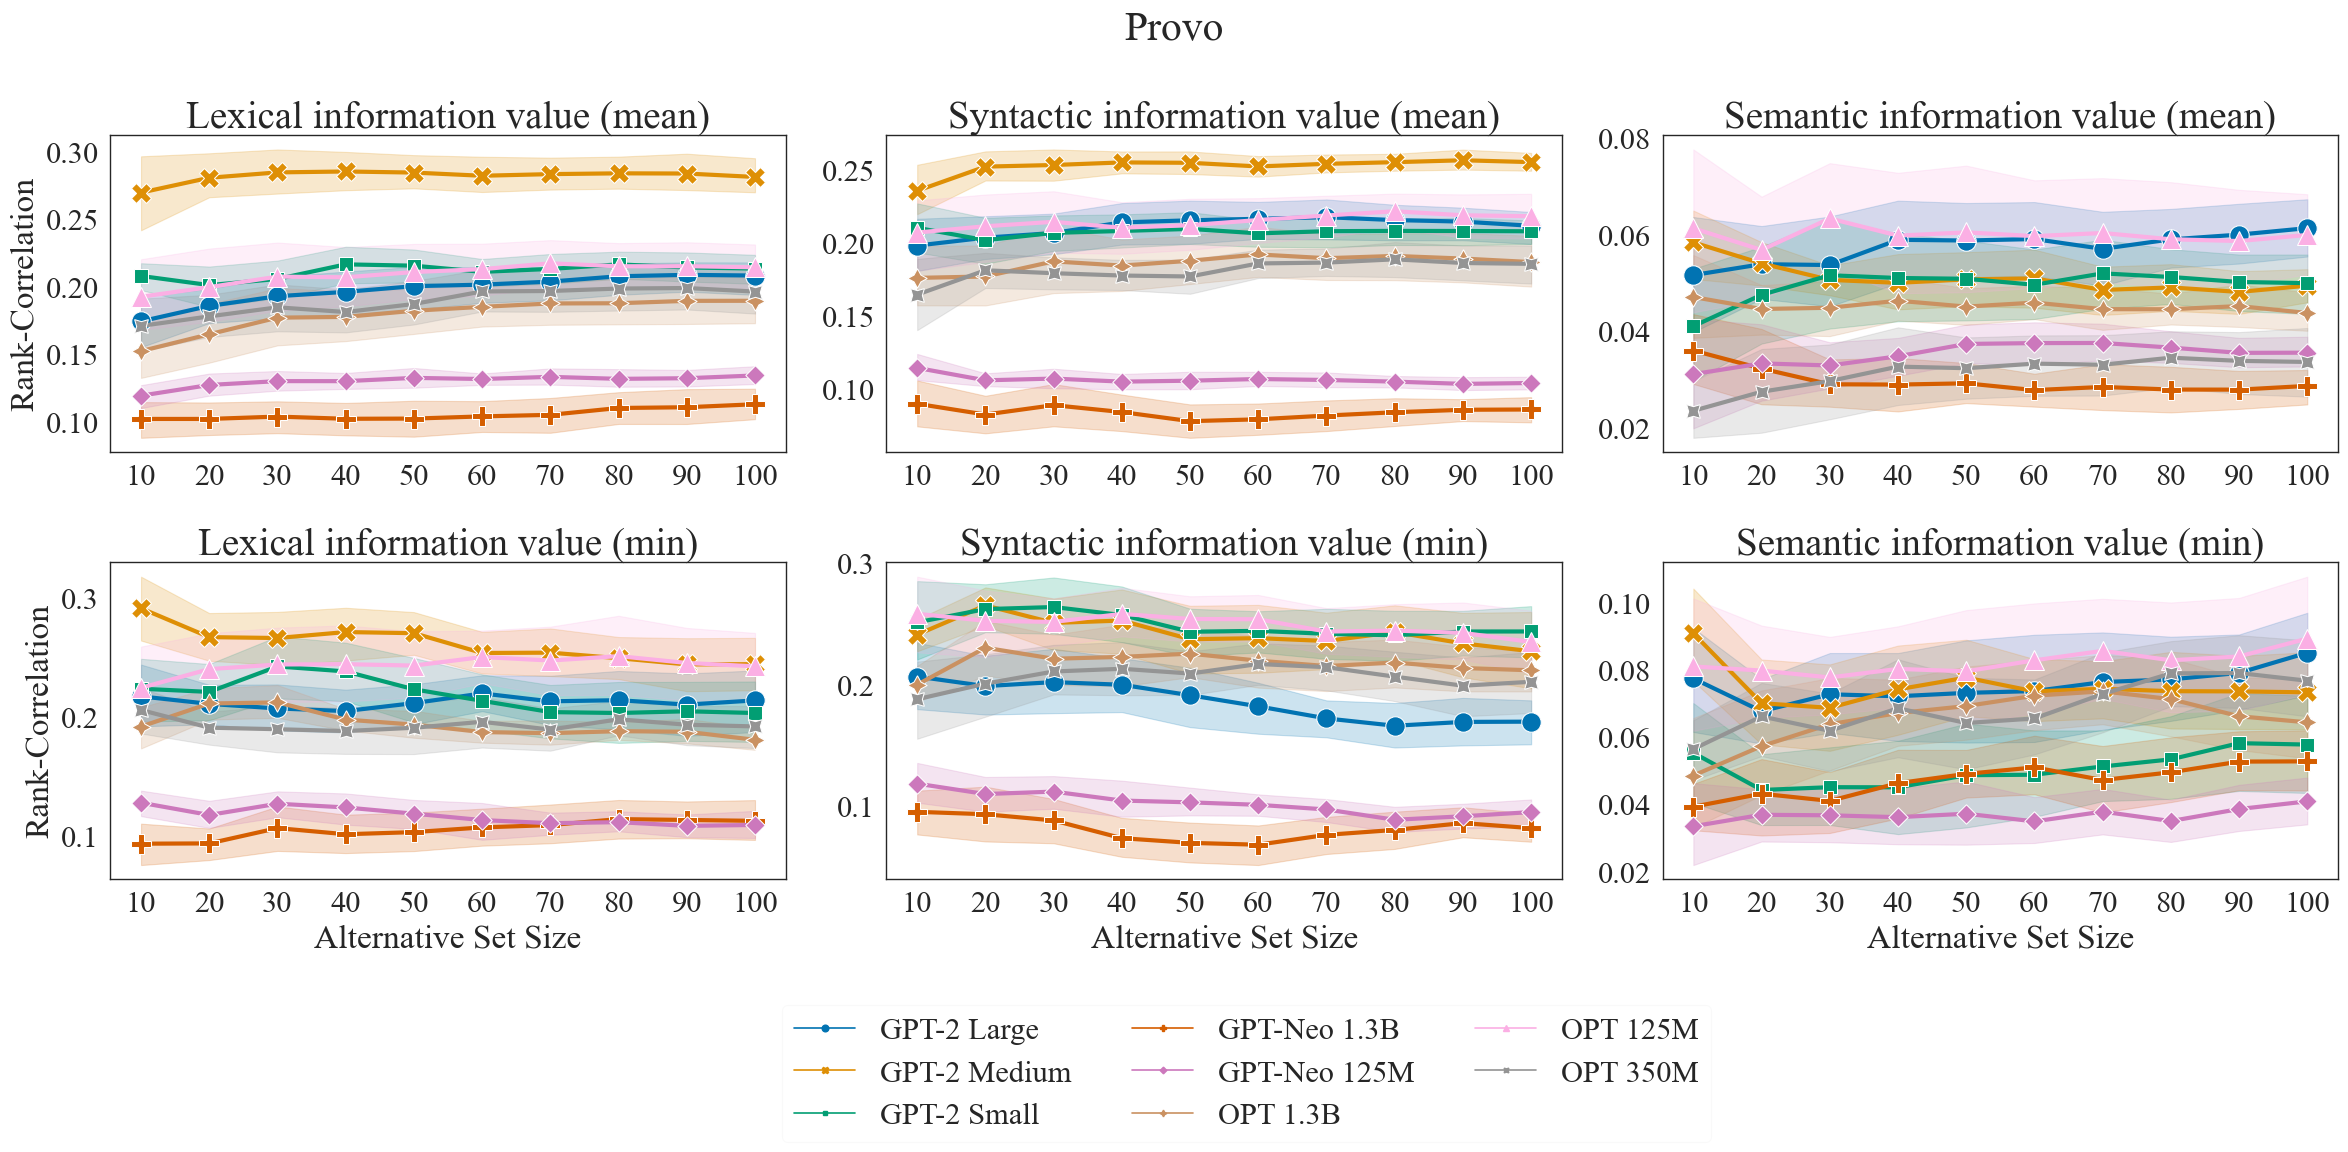

<Figure size 640x480 with 0 Axes>

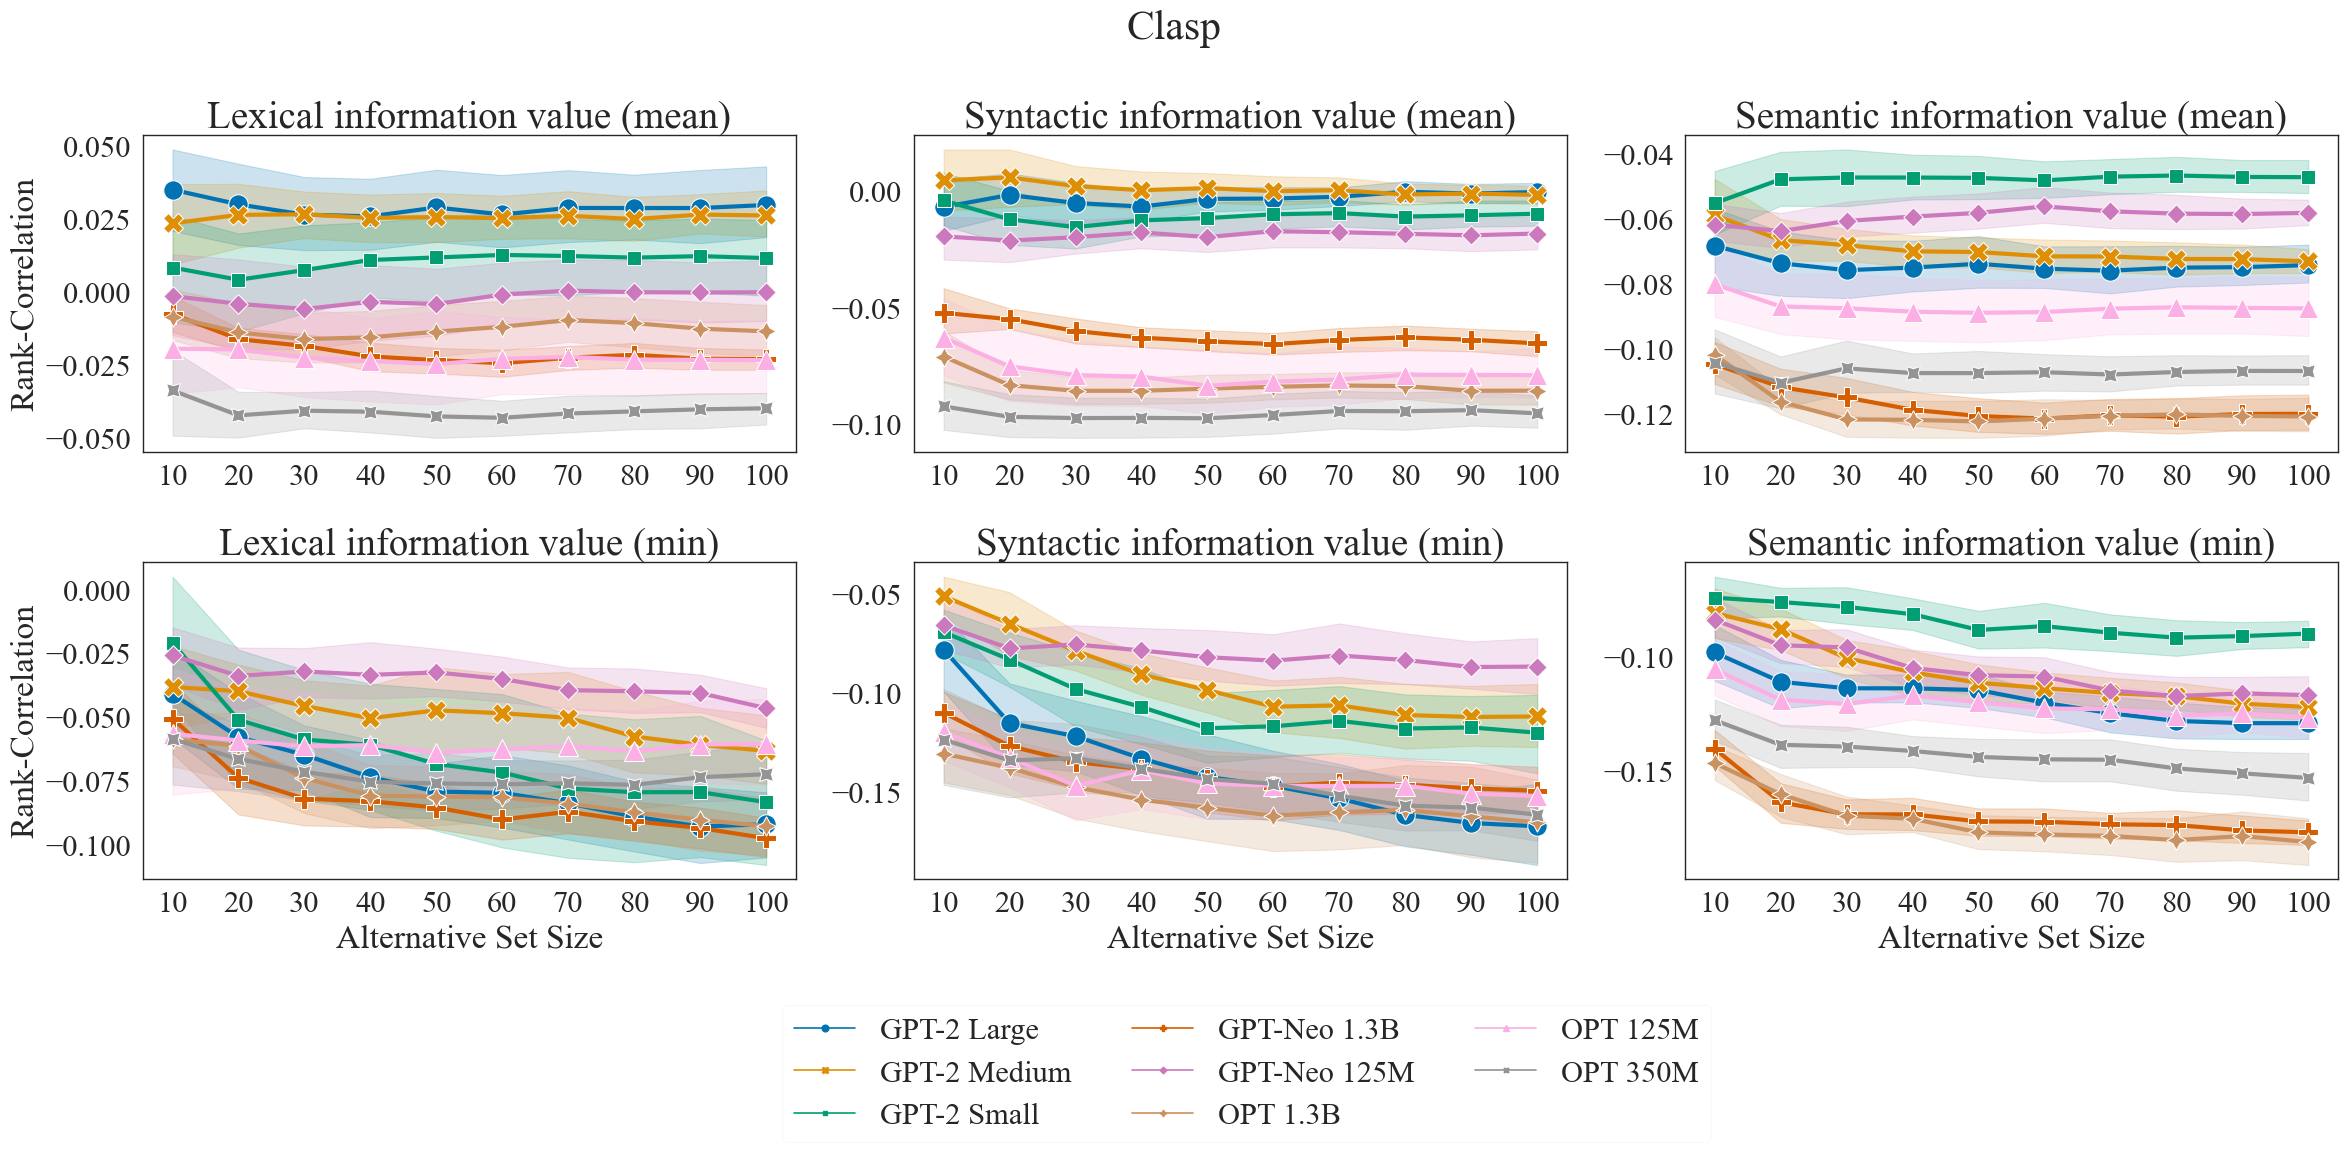

<Figure size 640x480 with 0 Axes>

In [239]:
plot_correlations_over_nsamples(quality_correlation_dfs, hue='model', save="../../../figures/")
